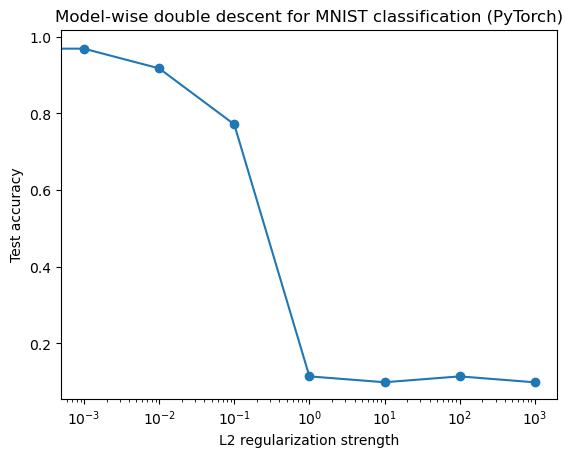

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=ToTensor())
test_dataset = MNIST(root='./data', train=False, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define neural network model
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define training loop
def train(model, train_loader, optimizer, criterion, reg_strength):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Add L2 regularization to the loss
        l2_reg = reg_strength * sum(p.norm(2)**2 for p in model.parameters())
        loss += l2_reg
        loss.backward()
        optimizer.step()

# Define testing loop
def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == targets).sum().item()
    acc = correct / len(test_loader.dataset)
    return acc

# Train and evaluate models with different regularization strengths
reg_strengths = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
test_accs = []
for reg_strength in reg_strengths:
    model = SimpleNet(input_size=784, hidden_size=128, output_size=10).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(10):
        train(model, train_loader, optimizer, criterion, reg_strength)
    test_acc = test(model, test_loader)
    test_accs.append(test_acc)

# Plot test accuracy versus regularization strength
plt.plot(reg_strengths, test_accs, 'o-')
plt.xscale('log')
plt.xlabel('L2 regularization strength')
plt.ylabel('Test accuracy')
plt.title('Model-wise double descent for MNIST classification (PyTorch)')
plt.show()
